<a href="https://colab.research.google.com/github/Pilo1961/QuestionAnswer_System/blob/master/code/05-testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test notebook
En este cuaderno hacemos todo el pipeline y predicciones para los datos de prueba.
Se puede empezar desde la sección *load pkl data* si ya tenemos generados los pickles con los datos

# Datos de prueba
En este cuaderno hacemos todo el pipeline para los datos de prueba.

In [0]:
import numpy as np
import pandas as pd
import json
import pickle

In [2]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Read data

In [59]:
# Lectura de datos
path= "/content/drive/My Drive/QA/dev-v1.0.json"
with open(path) as f: 
    d = json.load(f) 

df = pd.json_normalize(d['data'])  
print(df.shape)
df.head()

(48, 2)


,paragraphs,title
0,[{'context': 'Super Bowl 50 was an American fo...,Super_Bowl_50
1,[{'context': 'One of the most famous people bo...,Warsaw
2,[{'context': 'The Normans (Norman: Nourmands; ...,Normans
3,[{'context': 'Nikola Tesla (Serbian Cyrillic: ...,Nikola_Tesla
4,[{'context': 'Computational complexity theory ...,Computational_complexity_theory


In [60]:
# Pasamos del formato json al formato tabular
df=pd.json_normalize(data=d['data'],
                        record_path=['paragraphs','qas','answers'],
                        record_prefix=None,
                        meta_prefix=None,
                        meta=['title',
                              ['paragraph','context'],
                              ['paragraph','qas','question'],
                              ['paragraph','qas','id']])

df.rename(columns={'paragraph.context':'context','paragraph.qas.question':'question','paragraph.qas.id':'id'},inplace=True)
print(df.shape)
df.head()

(33615, 6)


,answer_start,text,title,context,question,id
0,176,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
1,177,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
2,177,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
3,248,Carolina Panthers,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed
4,249,Carolina Panthers,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed


In [61]:
print("dimensiones df",df.shape)
print("Nas \n", df.isna().sum())

dimensiones df (33615, 6)
Nas 
 answer_start    0
text            0
title           0
context         0
question        0
id              0
dtype: int64


### Observaciones
* Tenemos 33615 pregutnas en los datos de prueba  
* No tenemos valores faltantes

### Tokenizamos oraciones

In [62]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Tokeniza datos 
#Hace cada oracion un token
#Convierte todo el texto a minusculas
contextos=df['context'].unique()
data=[]
for cont in contextos: # para cada contexto
  sample=cont
  for sent in sent_tokenize(sample): #Extrae las oraciones
    data.append(sent.lower())

In [64]:
#Hay 10458 oraciones en el test, cada una es un token en la lista data
#Las guardamos en un arreglo llamado data
print(len(data))
data[:5]

10458


['super bowl 50 was an american football game to determine the champion of the national football league (nfl) for the 2015 season.',
 'the american football conference (afc) champion denver broncos defeated the national football conference (nfc) champion carolina panthers 24–10 to earn their third super bowl title.',
 "the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california.",
 'as this was the 50th super bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each super bowl game with roman numerals (under which the game would have been known as "super bowl l"), so that the logo could prominently feature the arabic numerals 50.',
 'the panthers finished the regular season with a 15–1 record, and quarterback cam newton was named the nfl most valuable player (mvp).']

# Embeddings de oraciones

En el cuaderno de embeddings habiamos entrenado los modelos para los datos de prueba. Usamos el mismo vocabulario que para los datos de entrenamiento y tenemos el diccionario guardado en un pickle.

In [0]:
#load train data from pickle
with open("/content/drive/My Drive/QA/test_dict.pkl", "rb") as f:
    test_dict = pickle.load(f)

with open("/content/drive/My Drive/QA/test_question.pkl", "rb") as f:
    test_question = pickle.load(f)

In [66]:
#Ejemplo del diccionario.
# Muestra una oracion y el embedding
i=1459

print("Longitud del diccionario: ",len(test_dict))
print("Oracion: ")
print(data[i])
print("Embedding: ")
test_dict[data[i]]

Longitud del diccionario:  10389
Oracion: 
teachers in wales can be registered members of trade unions such as atl, nut or nasuwt and reports in recent years suggest that the average age of teachers in wales is falling with teachers being younger than in previous years.
Embedding: 


array([ 0.11166224,  0.11551004,  0.09800068, ...,  0.15465239,
       -0.03260973,  0.05560881], dtype=float32)

# Transformations

In [0]:
#Genera una lista de listas para los contextos
#y para los embeddings de los contextos

contexts=[]
context_embedding=[]
last_context=[]

for context in df['context']:

  if context == last_context:# Si es el mismo contexto usa lo que ya calculamos
    contexts.append(temp)
    context_embedding.append(temp_emb)
    continue
  
  temp=[]
  temp_emb=[]
  for sent in sent_tokenize(context):
    s=sent.lower()
    temp.append(s)
    e=test_dict[s]
    temp_emb.append(e)
  
  contexts.append(temp)
  context_embedding.append(temp_emb)
  last_context=context


In [68]:
# Todas las variables tienen la misma longitud que el df original
print(len(context_embedding))
print(len(contexts))
print(len(test_question))

33615
33615
33615


In [69]:
#Busca la oracion que tiene la respuesta literal dentro del contexto
#guarda la posicion de la oracion dentro del contexto
# Si no la encuentra deja target = -1
df["target"]=-1
for i in range (len(df)):
  respuesta=df["text"][i].lower()
  for j, sent in enumerate(contexts[i]):
    if respuesta in sent: 
      df["target"][i] = j
      break


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [70]:
#casos que no se encontro la respuesta
sum(df["target"]==-1)

213

In [0]:
#quitamos las filas que no tienen target en el df
index=np.where(df["target"]==-1)
contexts=np.delete(contexts,index,axis=0)
context_embedding=np.delete(context_embedding,index,axis=0)
test_question=np.delete(test_question,index,axis=0)

#quitamos las filas que no tienen target en el df
index=df["target"]==-1
df=df[-index].reset_index()

In [72]:
# La nueva longitud de los datos
print(df.shape)
print(len(context_embedding))
print(len(contexts))
print(len(test_question))

(33402, 8)
33402
33402
33402


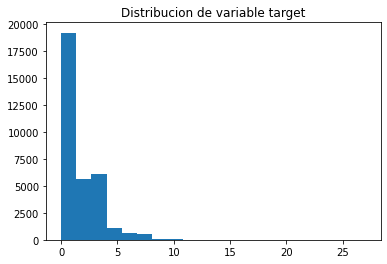

In [74]:
plt.hist(df["target"],bins=20)
plt.title("Distribucion de variable target")
plt.show()

In [76]:
print(np.quantile(df["target"],.99))
pd.DataFrame(df["target"]).describe()

8.0


,target
count,33402.000000
mean,1.630262
std,1.833376
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,27.000000


# Feature engineering

In [0]:
# Definimos las distancias a utilizar
norma=lambda x:np.sqrt(sum(x*x))
distancia_coseno=lambda x,y: 1-(sum(x*y)/(norma(x)*norma(y)))
distancia_euclidiana=lambda x,y: norma(x-y)

In [79]:
# Calcula la distancia coseno y la euclidiana entre las oraciones del contexto y la pregunta
# Devuevle un array target con el indice de la oracion con la minima distancia
euclid_distance_target=[]
cosine_distance_target=[]
euclid_distance=[]
cosine_distance=[]

for i in range(len(df)):
  dc_min=1000
  de_min=1000
  temp_c=[]
  temp_e=[]
  for j, sent_emb in enumerate(context_embedding[i]):
    dist_euc=distancia_euclidiana(sent_emb,test_question[i])
    dist_cos=distancia_coseno(sent_emb,test_question[i])  
    temp_c.append(dist_cos)
    temp_e.append(dist_euc)

  euclid_distance_target.append(np.argmin(temp_e))
  cosine_distance_target.append(np.argmin(temp_c))
  euclid_distance.append(temp_e)
  cosine_distance.append(temp_c)
  if i%5000==0: print(i)

0
5000
10000
15000
20000
25000
30000


In [0]:
df["euclid_prediction"]=euclid_distance_target
df["cosine_prediction"]=cosine_distance_target

In [0]:
import pickle

with open("/content/drive/My Drive/QA/dist_cosine_test.pkl", 'wb') as handle:
    pickle.dump(cosine_distance, handle)

with open("/content/drive/My Drive/QA/dist_euclid_test.pkl", 'wb') as handle:
    pickle.dump(euclid_distance, handle)

In [82]:
#Checa si la oracion que minimiza la distancia es la misma que la oracion target
euclid=0
cosine=0
for i in range(len(df)):
  right=df["target"][i]
  e=df["euclid_prediction"][i]
  c=df["cosine_prediction"][i]
  if(right==e):euclid+=1
  if(right==c):cosine+=1  

print("Cosine accuracy",cosine/len(df))
print("Euclidian accuracy",euclid/len(df))

Cosine accuracy 0.600862223818933
Euclidian accuracy 0.37036704388958747


### Prediccion de aprendizaje no supervizado
Revisa en que porcentaje de los casos del test coincide que la oración que minimiza la distancia es la oración que contiene la respuesta.
**Accuracy:**
* 60% usando distancia coseno
* 37% usando distancia euclidiana

In [86]:
#Celda para verificar consistencia
# El target y el index del mínimo deben de coincidir para cualquier i
i=np.random.randint(low=0,high=len(df))

print("i: ",i)
print("\n")
print("Distancia Euclidiana")
print(euclid_distance[i])
print("Target: ", euclid_distance_target[i])
print("Index del minimo:",np.argmin(euclid_distance[i]))
print("\n")
print("Distancia Coseno")
print(cosine_distance[i])
print("Target: ",cosine_distance_target[i])
print("Index del minimo:",np.argmin(cosine_distance[i]))

i:  18


Distancia Euclidiana
[4.75651837762449, 5.1710093046531265, 4.707001527234436, 5.454110317986277]
Target:  2
Index del minimo: 2


Distancia Coseno
[0.4714171165529033, 0.5630912257177372, 0.4877259776630214, 0.5526839301169767]
Target:  0
Index del minimo: 0


In [0]:
df_context_embedding=pd.DataFrame(context_embedding,columns=["context_embedding"])

### Root analysis

In [87]:
#Ejemplo de la estructura de una oración

import spacy
from nltk import Tree
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

en_nlp = spacy.load('en')
doc = en_nlp(contexts[0][3])
print(contexts[0][3])
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_


[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

as this was the 50th super bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each super bowl game with roman numerals (under which the game would have been known as "super bowl l"), so that the logo could prominently feature the arabic numerals 50.
                                                                                                                          emphasized                                                                                                                                                
  ____________________________________________________________________________________________________________________________|_________________________________                                                                                                                     
 |   |            |               |                                                              

[None]

In [88]:
# calcula las raices de las oraciones de los contextos
# calcula las raices de las pregutnas
# Genera un vector que contiene el numero de raices en cada indice

questions_root=[]
context_root=[]
num_roots=[]


for i in range(len(df)):
  if df["context"][i]!=last_context: 
    roots=[st.stem(str(sent.root)) for sent in en_nlp(df["context"][i]).sents]
  context_root.append(roots)
  num_roots.append(len(roots))
  questions_root.append([st.stem(str(sent.root)) for sent in en_nlp(df["question"][i]).sents])
  last_context=df["context"][i]
  if i%5000==0: print(i)

0
5000
10000
15000
20000
25000
30000


In [0]:
import pickle

with open("/content/drive/My Drive/QA/question_root_test.pkl", 'wb') as handle:
    pickle.dump(questions_root, handle)

with open("/content/drive/My Drive/QA/context_root_test.pkl", 'wb') as handle:
    pickle.dump(context_root, handle)

In [90]:
#hacemos un array con las posiciones en que coinciden la raiz de la pregunta y de las oraciones

root_index=[]

for i in range(len(questions_root)):
  c=[]
  a=np.array(context_root[i])
  b=np.array(questions_root[i])
  for root in b:
    temp=np.where(a==root)
    c=np.append(c,temp[0])
  root_index.append(c.astype('i'))
  if i%10000 ==0: print(i)


0
10000
20000
30000


In [0]:
#Hace un one hot encoder de los root. Limita los resultados a las dimensiones indicadas.
dim=9
root_ohe=[]
for i in range(len(root_index)):
  a=np.zeros(60)
  a[root_index[i]]=1
  root_ohe.append(a[:dim])

root_ohe=pd.DataFrame(root_ohe)

In [92]:
root_ohe.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
import pickle

with open("/content/drive/My Drive/QA/root_ohe_test.pkl", 'wb') as handle:
    pickle.dump(root_ohe, handle)

# Load pkl data
Podemos empezar el análisis desde aqui con todos los pickles que generamos en las celdas anteriores

In [0]:
import pickle
with open("/content/drive/My Drive/QA/root_ohe_test.pkl", "rb") as f:
    root_ohe = pickle.load(f)

with open("/content/drive/My Drive/QA/dist_euclid_test.pkl", "rb") as f:
    euclid = pickle.load(f)

with open("/content/drive/My Drive/QA/dist_cosine_test.pkl", "rb") as f:
    cosine = pickle.load(f)


In [114]:
df.head()

,index,answer_start,text,title,context,question,id,target,euclid_prediction,cosine_prediction
0,0,176,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec,1,0,0
1,1,177,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec,1,0,0
2,2,177,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec,1,0,0
3,3,248,Carolina Panthers,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed,1,0,0
4,4,249,Carolina Panthers,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed,1,0,0


In [116]:
print(len(euclid))
print(len(cosine))
print(root_ohe.shape)
print(len(df["target"]))

33402
33402
(33402, 9)
33402


# Modelos
### Ensamblamos la matriz de machine learning

In [117]:
root_ohe.columns=["root_0","root_1","root_2","root_3","root_4","root_5","root_6","root_7","root_8"]
root_ohe

,root_0,root_1,root_2,root_3,root_4,root_5,root_6,root_7,root_8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
33397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33398,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33399,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33400,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
#preparamos los datos de distancia euclidiana
df_euclid=pd.DataFrame(euclid)
df_euclid=df_euclid.iloc[:,0:9]
df_euclid.columns=["euc_0","euc_1","euc_2","euc_3","euc_4","euc_5","euc_6","euc_7","euc_8"]
df_euclid.fillna(50, inplace=True)#imputamos con un valor grande.
df_euclid

,euc_0,euc_1,euc_2,euc_3,euc_4,euc_5,euc_6,euc_7,euc_8
0,4.938536,5.216400,5.008254,5.501133,50.0,50.0,50.0,50.0,50.0
1,4.938536,5.216400,5.008254,5.501133,50.0,50.0,50.0,50.0,50.0
2,4.938536,5.216400,5.008254,5.501133,50.0,50.0,50.0,50.0,50.0
3,4.938536,5.216400,5.008254,5.501133,50.0,50.0,50.0,50.0,50.0
4,4.938536,5.216400,5.008254,5.501133,50.0,50.0,50.0,50.0,50.0
...,...,...,...,...,...,...,...,...,...
33397,3.126111,3.108962,4.235171,2.589668,50.0,50.0,50.0,50.0,50.0
33398,3.421005,3.437781,4.514416,2.837525,50.0,50.0,50.0,50.0,50.0
33399,3.421005,3.437781,4.514416,2.837525,50.0,50.0,50.0,50.0,50.0
33400,3.421005,3.437781,4.514416,2.837525,50.0,50.0,50.0,50.0,50.0


In [119]:
#preparamos los datos de distancia coseno
df_cos=pd.DataFrame(cosine)
df_cos=df_cos.iloc[:,0:9]
df_cos.columns=["cos_0","cos_1","cos_2","cos_3","cos_4","cos_5","cos_6","cos_7","cos_8"]
df_cos.fillna(5, inplace=True)#imputamos con un valor grande.
df_cos

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8
0,0.530199,0.594889,0.585700,0.578876,5.0,5.0,5.0,5.0,5.0
1,0.530199,0.594889,0.585700,0.578876,5.0,5.0,5.0,5.0,5.0
2,0.530199,0.594889,0.585700,0.578876,5.0,5.0,5.0,5.0,5.0
3,0.530199,0.594889,0.585700,0.578876,5.0,5.0,5.0,5.0,5.0
4,0.530199,0.594889,0.585700,0.578876,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...
33397,0.245094,0.262238,0.334022,0.224378,5.0,5.0,5.0,5.0,5.0
33398,0.306608,0.339873,0.394059,0.298434,5.0,5.0,5.0,5.0,5.0
33399,0.306608,0.339873,0.394059,0.298434,5.0,5.0,5.0,5.0,5.0
33400,0.306608,0.339873,0.394059,0.298434,5.0,5.0,5.0,5.0,5.0


In [0]:
# Concatenamos los datos de distancias y raiz de la oracion
mat=pd.concat([root_ohe,df_cos,df_euclid],ignore_index=True,axis=1)

In [121]:
# info de la matriz
mat=mat.to_numpy()
print(mat.shape)

(33402, 27)


Normalizamos las variables

In [0]:
#noramlizamos variables
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
mat=scaler.fit_transform(mat)

### Variable target

In [123]:
y=df["target"].to_numpy()
len(y)

33402

# Modelo

In [0]:
#Cargamos el mejor modelo
import pickle

with open("/content/drive/My Drive/QA/best_model.pkl", "rb") as f:
    clf=pickle.load(f)
# jala el pickle del modelo

In [126]:
#hacer predicciones
clf.score(mat, y)

0.5958924615292498

Tenemos un resultado de 59.58% en los datos test